<h1 style="background-color:#EEEEEE; color:#222831; text-align:left; font-family:Georgia">Object Detection using RCNN</h1>

Training a typical object detection model would involve the following steps:
1. Creating ground truth data that contains labels of the bounding box and class corresponding to various objects present in the image.
2. A mechanism to scan through the image to identify regions (region proposals) that are likely to contain objects. Here, we use selectivesearch (module) for it
3. Creating the target class variable by using the IoU metric.
4. Creating the target bounding box offset variable to make corrections to the location of region proposal coming in the second step. The offset here is the delta difference between the ground truth bounding box and the region proposal through selectivesearch
5. Building a model that can predict the class of object along with the target bounding box offset corresponding to the region proposal.
6. Measuring the accuracy of object detection using mean Average Precision (mAP).

In [ ]:
!pip install -q --upgrade selectivesearch torch_snippets

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from torch_snippets import *
import selectivesearch
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import numpy as np

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
IMAGE_ROOT = '/content/gdrive/MyDrive/images/images'
DF_RAW = pd.read_csv('/content/df.csv')
print(DF_RAW.head())

ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.343750  0.795000  0.908750  0.156162  0.512700  0.650047   
1  0.299167  0.276667  0.697500  0.659167  0.141604  0.241855  0.352130   
2  0.849167  0.702500  0.906667  0.999167  0.204261  0.398496  0.409774   
3  0.274375  0.371250  0.311875  0.156250  0.269188  0.493882  0.705228   
4  0.920000  0.999375  0.648750  0.287500  0.194184  0.303940  0.999062   

   XClick4Y  
0  0.457197  
1  0.437343  
2  0.295739  
3  0.521691  
4  0.523452  

[5 rows x 21 columns]

In [ ]:
class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}.jpg'
        image = cv2.imread(image_path, 1)[...,::-1] # convert BGR to RGB
        # Basically x[...], it is similar to cv2.imread(image_path, 1)[:, :, ::-1], but this kinda works with any dimensions by mentioning just three dots
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist() #boxes in accordance to the image
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path
ds = OpenImages(df=DF_RAW)


For some images, there are multiple bounding boxes that may/may not belong to the same class. Below is an example:

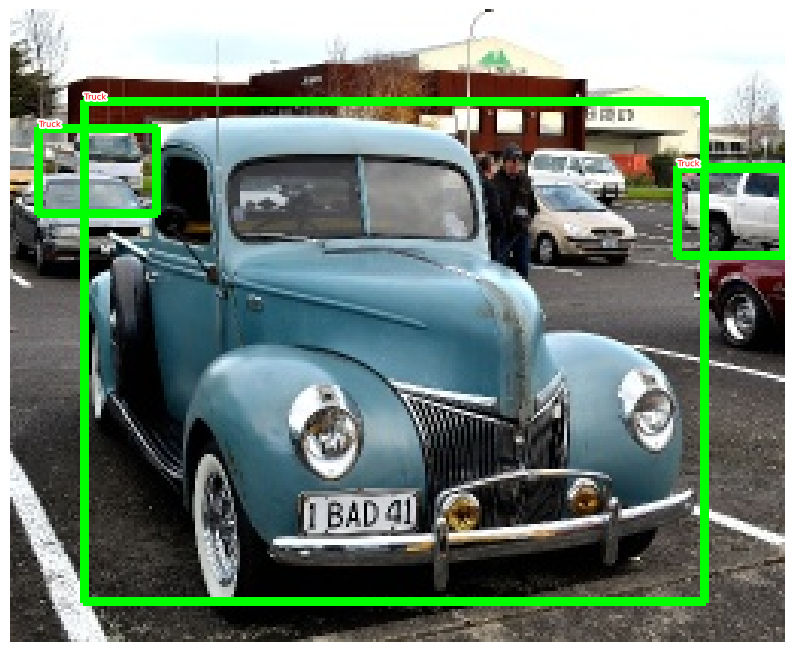

[[9, 39, 48, 67], [24, 30, 229, 195], [220, 52, 255, 81]]

In [ ]:
im, bbs, clss, _ = ds[6]
show(im, bbs=bbs, texts=clss, sz=10)
print(bbs)

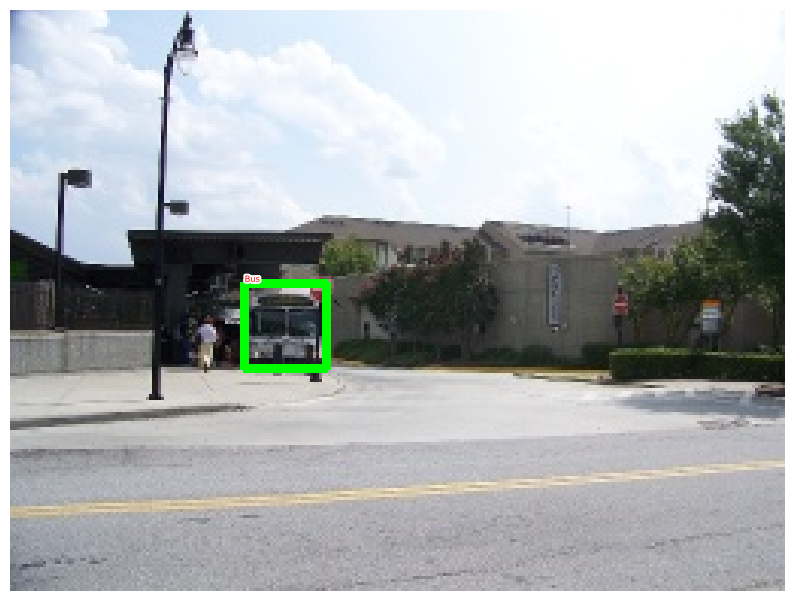

[[77, 90, 104, 118]]

In [ ]:
im, bbs, clss, _ = ds[15]
show(im, bbs=bbs, texts=clss, sz=10)
print(bbs)

The dimensions of the bounding box of the bus object is best understood in the following way -

![42193EA1-F670-417C-B5CD-37714DDBD836_1_201_a.jpeg](attachment:5c1fc7d3-4237-4da7-bbc0-212b74f78c5a.jpeg)

<h2 style="background-color:#EEEEEE; color:#222831; text-align:left; font-family:Georgia">SelectiveSearch to generate region proposals</h2>

SelectiveSearch is a region proposal algorithm used for object localization where it generates proposals of regions that are likely to be grouped together based on their pixel intensities. SelectiveSearch groups pixels based on the hierarchical grouping of similar pixels, which, in turn, leverages the color, texture, size, and shape compatibility of content within an image.

In [ ]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

#how iou works
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)  #change in x-direction
    height = (y2 - y1)  #change in y-direction
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height # this was calculated by x1, y1, x2, y2
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

### Selectivesearch module

The selectivesearch creates multiple candidate bounding boxes randomly, to be passed along with the input image. The IoU (Intersection over Union) is the loss metric here, hence, the bounding box with the highest IoU to the original bounding box target will be accepted.

(38, 4)

<class 'list'>

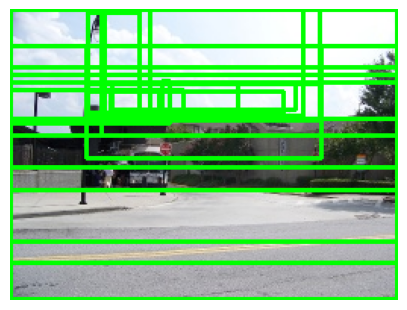

In [ ]:
# Example of df[15]
candidates = extract_candidates(im)
print(np.shape(candidates))
print(type(candidates))
show(im, bbs = candidates)

In [ ]:
help(show)

Help on function show in module torch_snippets.loader:

show(img=None, ax=None, title=None, sz=None, bbs=None, confs=None, texts=None, bb_colors=None, cmap='gray', grid=False, save_path=None, text_sz=None, df=None, pts=None, conns=None, interactive=False, *, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    show an image



In [ ]:
np.shape(ds[15])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(4,)

Best IoU: 0.14555256036666817

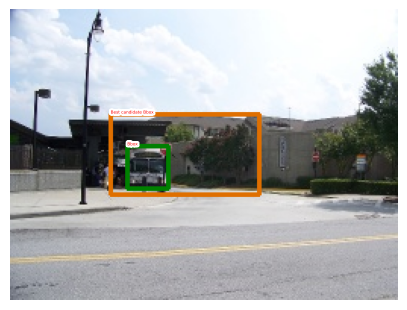

In [ ]:

(im, bbs, labels, fpath) = ds[15]
H, W, _ = im.shape
candidates = extract_candidates(im)
candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])  # candidates extracted are the x,y,w,h way and made x1, y1, x2, y2 to be similar to the bbs in the dataset

ious, rois, clss, deltas, best_ious = [], [], [], [], []
temp_best_bbs = []
ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T

for jx, candidate in enumerate(candidates):
    cx,cy,cX,cY = candidate
    candidate_ious = ious[jx]  #ious for that candidate
    best_iou_at = np.argmax(candidate_ious)  #best candidate iou is taken (index) ~ always be a zero index
    best_iou = candidate_ious[best_iou_at]   #gets the best score here
    best_ious.append(best_iou)
    best_bb = _x,_y,_X,_Y = bbs[best_iou_at] # gets the target label bounding box where there is the highest iou
    temp_best_bbs.append(best_bb)
    if best_iou > 0.3: clss.append(labels[best_iou_at]) # if iou is more than 0.3 it is not the background
    else : clss.append('background')
    delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])  #normalizing the delta based on image size
    deltas.append(delta)
    rois.append(candidate / np.array([W,H,W,H]))

best_ious_at = np.argmax(best_ious)
print("Best IoU:", best_ious[best_ious_at])


best_candidate = candidates[best_ious_at]
best_bbs = temp_best_bbs[best_ious_at]

# Example of df[15]
candidates = extract_candidates(im)
show(im, bbs = [best_bbs, best_candidate], confs= [0,0.5], texts = ['Bbox', 'Best candidate Bbox'])

In [ ]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break
    H, W, _ = im.shape
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        # if iou is more than 0.3 it is not the background
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]] #?

In [ ]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']



print("The label to target values dictionary formed is:" ,label2target)

The label to target values dictionary formed is:
{'Bus': 0, 'background': 1, 'Truck': 2}

In [ ]:
# normalizing with the mean, std used while training the model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
def decode(_y):
    _, preds = _y.max(-1)
    return preds


In [ ]:
class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]  # bounding box image crops
        return image, crops, bbs, labels, deltas, gtbbs, fpath
    def collate_fn(self, batch):
        '''Performing actions on a batch of images'''
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas


In [ ]:
n_train = 9*len(FPATHS)//10 # 0.9 is the train size
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

In [ ]:
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False #not to do a re-train
vgg_backbone.eval().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 121MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

<h2 style="background-color:#EEEEEE; color:#222831; text-align:left; font-family:Georgia">R-CNN network architecture</h2>

The following strategy is adopted for R-CNN network architecture

1. Define a VGG backbone.
2. Fetch the features post passing the normalized crop through a pretrained model.
3. Attach a linear layer with sigmoid activation to the VGG backbone to predict the class corresponding to the region proposal.
4. Attach an additional linear layer to predict the four bounding box offsets.
5. Define the loss calculations for each of the two outputs (one to predict class and the other to predict the four bounding box offsets).
6. Train the model that predicts both the class of region proposal and the four bounding box offsets.

In [ ]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25088
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        self.cel = nn.CrossEntropyLoss() # loss for classification
        self.sl1 = nn.L1Loss() # loss for regression
    def forward(self, input):
        feat = self.backbone(input)  # both classification and regression takes 'feat' as input
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox
    def calc_loss(self, probs, _deltas, labels, deltas):
        # probs is basically the predicted class
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != 1) #removing the label 1, which is background
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            # every ix is detected as background
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

In [ ]:
def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input)  # as model outputs we will be getting classes and delta (bbox offsets)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [ ]:
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)  # more like a softmax np argmax
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [ ]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs) #records the metrics as report, can be used to plot later

In [ ]:
# loc_loss: loss on classification
# regr_loss: loss on regression

for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn,
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss,
                   trn_regr_loss=regr_loss,
                   trn_acc=accs.mean(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs,
                                                rcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss,
                val_regr_loss=regr_loss,
                val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics


<ipython-input-16-7394c18a65d2>:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  deltas = torch.Tensor(deltas).float().to(device)


EPOCH: 5.000  val_loss: 1.458  val_loc_loss: 0.569  val_regr_loss: 0.089  val_acc: 0.727  (713.18s - 0.00s remaining)

100%|██████████| 106/106 [00:00<00:00, 1881.76it/s]


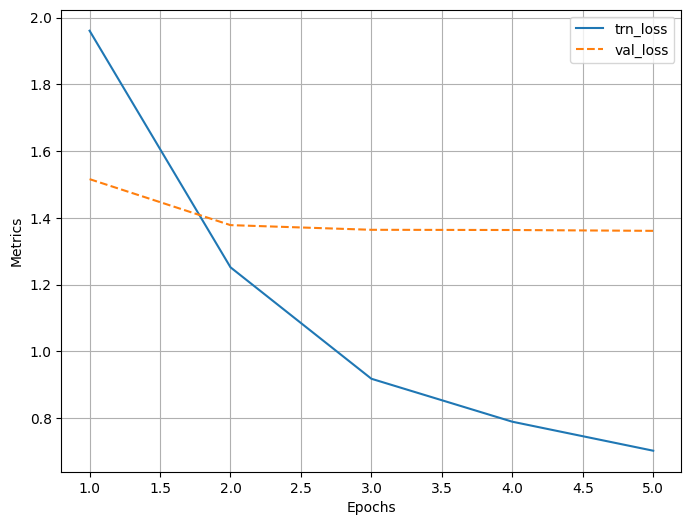

In [ ]:
log.plot_epochs('trn_loss,val_loss'.split(','))

100%|██████████| 106/106 [00:00<00:00, 1706.24it/s]


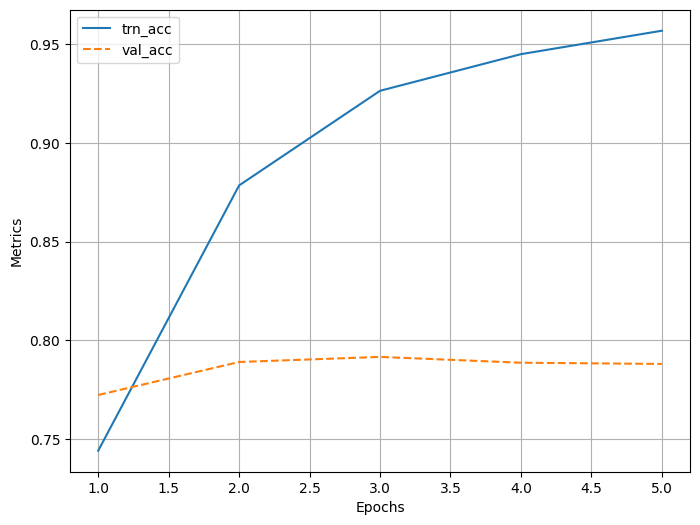

In [ ]:
log.plot_epochs('trn_acc,val_acc'.split(','))

<h2 style="background-color:#EEEEEE; color:#222831; text-align:left; font-family:Georgia">NMS (Non-max suppression)</h2>

- Non-max refers to the boxes that do not contain the highest probability of containing an object, and suppression refers to us discarding those boxes that do not contain the highest probabilities of containing an object. In non-max suppression, we identify the bounding box that has the highest probability and discard all the other bounding boxes that have an IoU greater than a certain threshold with the box containing the highest probability of containing an object.
- Using non-max suppression nms to eliminate near-duplicate bounding boxes: pairs of boxes that have an IoU greater than 0.05 are considered duplicates in this case. Among the duplicated boxes, we pick that box with the highest confidence and discard the rest

In [ ]:
def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)  #Concatenates the given sequence of seq tensors in the given dimension
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        print("Shape of probs", np.shape(probs))
        print("Shape of deltas", np.shape(deltas))
        probs = torch.nn.functional.softmax(probs, -1)  # probability is put between 0 and 1 by doing a softmax
        confs, clss = torch.max(probs, -1) #-1 is the dimension in which the max (reduction) must happen -> confs tells me the confidence and clss tells me the class where it has found the max probs
        print("Shape of confs", np.shape(confs))
        print("Shape of clss", np.shape(clss))
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        # condition that even after nms, many ixs come for the bbox
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)  # index
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title('Predicted object: ' + target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1])
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf

Shape of probs
torch.Size([45, 3])

Shape of deltas
torch.Size([45, 4])

Shape of confs
torch.Size([45])

Shape of clss
torch.Size([45])

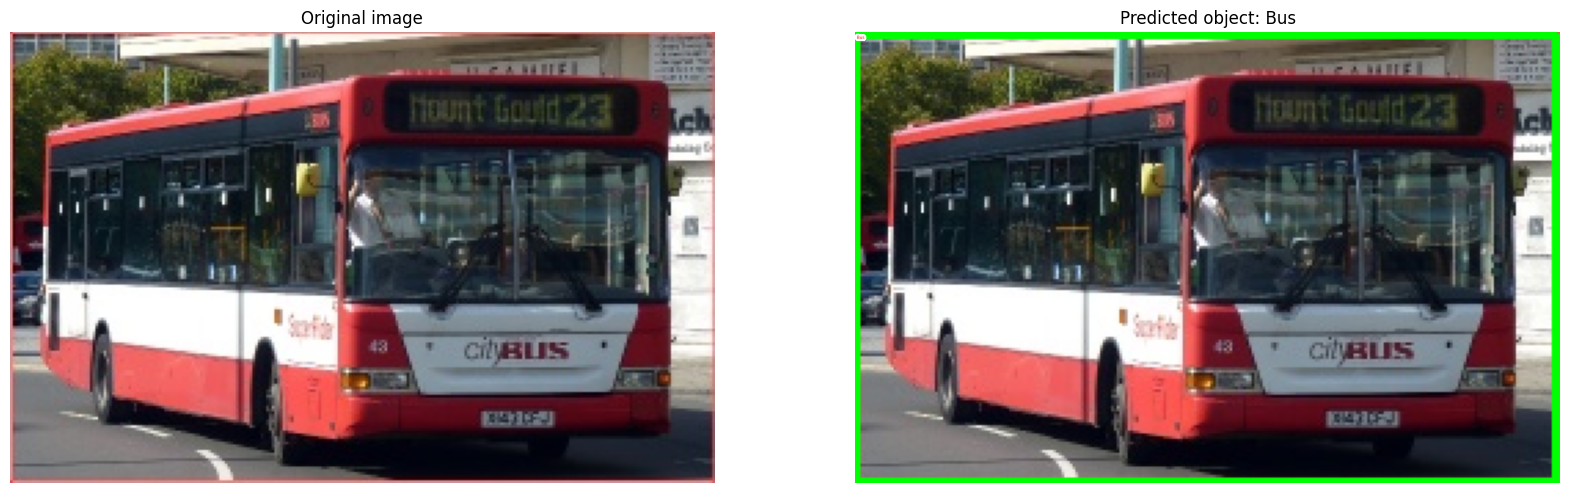

((0, 1, 254, 163), 'Bus', 0.99999654)

In [ ]:
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[6]
test_predictions(fpath)